In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from IPython import display as ipythondisplay
import imageio
import pickle

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible = 0, size = (400, 300))
display.start()

### Environment

In [ ]:
env = gym.make('Assault-v0').unwrapped

print(env.action_space.n)
print(env.observation_space)
print(env.get_action_meanings())

7
Box(0, 255, (250, 160, 3), uint8)
['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


(250, 160, 3)


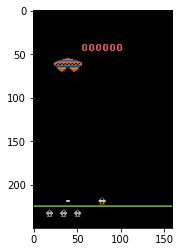

In [ ]:
env.reset()
screen = env.render(mode = 'rgb_array')
plt.imshow(screen)
print(screen.shape)

torch.Size([1, 64, 50])


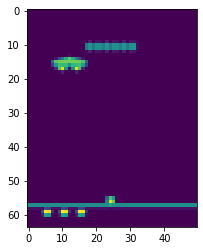

In [ ]:
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resize = T.Compose([T.ToPILImage(), T.Grayscale(), T.Resize((64, 50), interpolation = Image.BICUBIC), T.ToTensor()])

def get_screen(screen):
    screen = screen.transpose((2, 0, 1))
    screen = np.ascontiguousarray(screen, dtype = np.float32) / 255
    screen = torch.from_numpy(screen)
    
    return resize(screen).to(device)

print(get_screen(env.render(mode='rgb_array')).size())
env.reset()
plt.figure()
plt.imshow(get_screen(env.render(mode='rgb_array')).cpu().squeeze(0).numpy(), interpolation = 'none')
plt.show()


### Agent

In [ ]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 16, kernel_size = 3, stride = 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout2d(0.2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size = 3, stride = 2)
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout2d(0.2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size = 3, stride = 2)
        self.bn3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout2d(0.5)
        # self.conv4 = nn.Conv2d(64, 128, kernel_size = 5, stride = 2)
        # self.bn4 = nn.BatchNorm2d(128)

        conv2d_size_out = lambda size, kernel_size = 3, pad = 0, stride = 2 : (size + (2 * pad) - kernel_size) // stride  + 1

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        # print(convw, convh)
        flatten_input_size = convw * convh * 64
        print(flatten_input_size)
        self.fc1 = nn.Linear(flatten_input_size, 128)
        self.fc2 = nn.Linear(128, outputs)

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout3(F.relu(self.bn3(self.conv3(x))))
        # x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.fc1(x.view(x.size(0), -1)))
        x = self.fc2(x)
        return x
  

In [ ]:
from collections import deque, namedtuple
# ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque()

    def push(self, *args):
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
            self.memory.popleft()

    def sample(self, batch_size):
        idx = np.random.choice(len(self.memory), batch_size)
        return np.array(self.memory)[idx]

    def __len__(self):
        return len(self.memory)

In [ ]:
class Double_DQN_Agent:
    def __init__(self, env, epsilon = 1.0, lr = 0.0000625, gamma = 0.99, bufferSize = 1000000, tau = 0.1):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space
        self.epsilon = epsilon
        self.gamma = gamma
        _, h, w = get_screen(env.render(mode='rgb_array')).size()
        self.online_net = DQN(h, w, self.action_space.n).to(device)
        self.target_net = DQN(h, w, self.action_space.n).to(device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.RMSprop(self.online_net.parameters(), lr = lr)
        self.criterion = nn.SmoothL1Loss()
        self.memory = ReplayMemory(bufferSize)
        self.tau = tau

    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def step(self, state):
        if np.random.random() < self.epsilon:
            return torch.tensor([[np.random.choice(self.action_space.n)]], device = device, dtype = torch.long)
        else:
            with torch.no_grad():
                a = self.online_net(state)
                # print(a)
                return a.max(1)[1].view(1, 1)

    def populateReplayMemory(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)
    
    # ref: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    def train(self, batch_size = 32):
        if len(self.memory) < 5000:
            return
        transitions = self.memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        non_terminal_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device = device, dtype = torch.bool)
        non_terminal_next_states = torch.cat([s for s in batch.next_state if s is not None])
        
        state = torch.cat(batch.state)
        action = torch.cat(batch.action)
        reward = torch.cat(batch.reward)

        # print(state.shape)
        state_action_values = self.online_net(state).gather(1, action)

        next_state_values = torch.zeros(batch_size, device = device)
        next_state_actions = self.target_net(non_terminal_next_states).max(1, keepdim = True)[1]
        next_state_values[non_terminal_mask] = self.online_net(non_terminal_next_states).gather(1, next_state_actions).squeeze(1).detach()
        
        expected_state_action_values = (next_state_values * self.gamma) + reward

        loss = self.criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # train the model
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.online_net.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

    def updateWeights(self):
        target_state_dict = self.target_net.state_dict()
        online_state_dict = self.online_net.state_dict()
        for key in online_state_dict:
            target_state_dict[key] = self.tau * online_state_dict[key] + (1 - self.tau) * target_state_dict[key]
        self.target_net.load_state_dict(target_state_dict)

    def test(self):
        self.env.reset()
        images = [self.env.render(mode='rgb_array')]

        last_screen = get_screen(self.env.render(mode='rgb_array'))
        state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
        i = 0
        start = True
        done = False
        while not done:
            action = torch.tensor([1], device = device) if start else self.step(state)
            if start:
                start = False
            next_screen, reward, done, info = self.env.step(action.item())
            images.append(next_screen)
            next_screen = get_screen(next_screen)

            if done:
                next_state = None
            else:
                next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
                
            state = next_state

        imageio.mimsave('result_atari.gif', images, fps = 40)
        return images

    def saveWeights(self, path):
        torch.save(self.online_net.state_dict(), path)
    
    def loadWeights(self, path):
        self.online_net.load_state_dict(torch.load(path))


### MDP

In [ ]:
agent = Double_DQN_Agent(env)

episodes = 1000
target_update = 4
epsilon = agent.epsilon
epsilons = []
delta_epsilon = epsilon / episodes
epsilons = [epsilon]
total_rewards = []

for episode in range(episodes):
    env.reset()
    done = False
    if episode > 0:
        epsilon = epsilon - (5 * epsilon * delta_epsilon)
        epsilons.append(epsilon)
        agent.set_epsilon(epsilon)
    
    last_screen = get_screen(env.render(mode='rgb_array'))
    state = torch.cat([last_screen, last_screen, last_screen, last_screen]).unsqueeze(0)
    # print(state.shape)
    curr_reward = 0
    i = 0
    while not done:
        action = agent.step(state)
        next_screen, reward, done, info = env.step(action.item())
        curr_reward += reward

        # clipping the rewards to range [-1, 1]
        if reward > 0:
            reward = 1
        elif reward == 0:
            reward = 0
        else:
            reward = -1

        reward = torch.tensor([reward], device = device)
        next_screen = get_screen(next_screen)

        if done:
            next_state = None
        else:
            next_state = torch.cat((state[:, 1:, :, :], next_screen.unsqueeze(0)), dim = 1)
            
        agent.populateReplayMemory(state, action, next_state, reward)

        state = next_state
        if i % 3 == 0:
            agent.train()
        i += 1
        
    if episode % target_update == 0:
        agent.updateWeights()
    
    total_rewards.append(curr_reward)
    
    if (episode + 1) % 50 == 0:
        print(f'{episode + 1} episode completed.')

print('Complete')

2240
2240
50 episode completed.
100 episode completed.
150 episode completed.
200 episode completed.
250 episode completed.
300 episode completed.
350 episode completed.
400 episode completed.
450 episode completed.
500 episode completed.
550 episode completed.
600 episode completed.
650 episode completed.
700 episode completed.
750 episode completed.
800 episode completed.
850 episode completed.
900 episode completed.
950 episode completed.
1000 episode completed.
1050 episode completed.
1100 episode completed.
1150 episode completed.
1200 episode completed.
1250 episode completed.
Complete


In [ ]:
def plotGraphs(epsilons, total_rewards):
    # Plotting ε vs Episodes
    plt.figure(1)
    plt.title('Epsilon decay')
    plt.xlabel('Episodes')
    plt.ylabel('$\epsilon$')
    plt.plot(epsilons)
    plt.savefig('Epsilon_decay.png')

    # Plotting Total rewards received vs Episodes
    plt.figure(2)
    step = 10
    plt.title('Rewards dynamics')
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward (SMA 10)')
    plt.plot([np.mean(total_rewards[i : i + step]) for i in range(len(total_rewards))])
    plt.savefig('Rewards_dynamics.png')


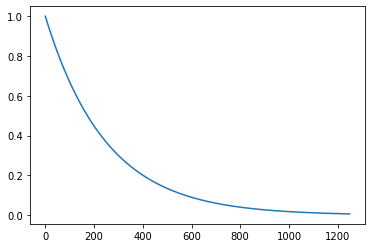

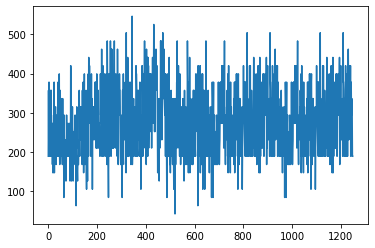

In [ ]:
plotGraphs(epsilons, total_rewards)

In [ ]:
agent.saveWeights('DoubleDQN_Atari')

In [ ]:
agent = Double_DQN_Agent(env)
agent.loadWeights('DoubleDQN_Atari')
imgs = agent.test()
print(len(imgs))


2240
2240
879
